In [1]:
#!pip install reverse_geocoder
#!pip install plotly_express

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import reverse_geocoder as rg
import statsmodels.formula.api as sm
#import plotly.graph_objects as go
#import plotly_express as px


# disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Output
#  df_ts_complete: df with values where time series is complete
#  df_estimate: df where all time series values are NaN but there is an estimate
#  df_ts_incomplete: df with values where at least one of time series values is NaN
# 
# Reads global powerplant data data from CSV, drops irrelevant columns, splits df (see output), 
# and re-indexes df with gppdf_idnr as index
def read_clean_and_split():  
    df = pd.read_csv("global_power_plant_database.csv")
    df_all = df.drop(['country_long', 'url', 'geolocation_source', 'wepp_id'], axis=1)
    
    df_ts = (df_all.dropna(how='all', subset=['generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017'])
                      .set_index('gppd_idnr'))
    df_ts_complete = df_ts.dropna(how='any', subset=['generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017'])
    df_estimate = (df_all.dropna(how='any', subset=['estimated_generation_gwh'])
                   .set_index('gppd_idnr'))
    df_ts_incomplete = df_ts[df_ts[['generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017']].isnull().any(axis=1)]
    return df_all, df_ts_complete, df_ts_incomplete, df_estimate     

In [3]:
df_all, df_ts_complete, df_ts_incomplete, df_estimate = read_clean_and_split()
df_all.head()

,country,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,other_fuel3,commissioning_year,owner,source,year_of_capacity_data,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,estimated_generation_gwh
0,AFG,Kajaki Hydroelectric Power Plant Afghanistan,GEODB0040538,33.00,32.3220,65.1190,Hydro,NaN,NaN,NaN,NaN,NaN,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,Mahipar Hydroelectric Power Plant Afghanistan,GEODB0040541,66.00,34.5560,69.4787,Hydro,NaN,NaN,NaN,NaN,NaN,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,NaN
2,AFG,Naghlu Dam Hydroelectric Power Plant Afghanistan,GEODB0040534,100.00,34.6410,69.7170,Hydro,NaN,NaN,NaN,NaN,NaN,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,NaN
3,AFG,Nangarhar (Darunta) Hydroelectric Power Plant ...,GEODB0040536,11.55,34.4847,70.3633,Hydro,NaN,NaN,NaN,NaN,NaN,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,NaN
4,AFG,Northwest Kabul Power Plant Afghanistan,GEODB0040540,42.00,34.5638,69.1134,Gas,NaN,NaN,NaN,NaN,NaN,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,NaN


# EDA
## 1. Plot distribution of capacity for each fuel type

In [4]:
# Group by the fuel type
fueltype = df_all.groupby("primary_fuel")
fueltype.describe()

capacity_mw                                             \
                     count         mean          std   min        25%   
primary_fuel                                                            
Biomass             1396.0    24.667408    39.970655   1.0     3.0000   
Coal                2390.0   836.619247   883.792022   1.2   200.0000   
Cogeneration          41.0    97.624390   283.717419   1.6     7.5000   
Gas                 3922.0   375.495683   562.794664   1.0    31.1250   
Geothermal           189.0    66.473810   114.770905   1.0    18.0000   
Hydro               7155.0   146.804321   549.433962   1.0     5.3000   
Nuclear              198.0  2069.832626  1304.270269  20.0  1100.0000   
Oil                 2290.0   114.565943   394.966198   1.0     2.5404   
Other                 44.0    85.399091   144.155122   4.5    17.5000   
Petcoke               13.0   192.082885   458.141449   4.7    27.3000   
Solar               5929.0    10.747651    26.418461   1.0     2.0000   
Storage               58.0     7.820690     9.682517   1.0     2.0000   
Waste               1087.0    13.898081    20.690791   1.0     2.3000   
Wave and Tidal        10.0    55.220000   101.440708   1.0     1.4000   
Wind                5188.0    46.299842   102.712898   1.0    10.0000   

                                            latitude             ...  \
                    50%       75%       max    count       mean  ...   
primary_fuel                                                     ...   
Biomass            9.95    29.175    528.00   1396.0  19.364704  ...   
Coal             600.00  1200.000   7000.00   2390.0  32.725796  ...   
Cogeneration      30.00    49.300   1404.00     41.0  38.124766  ...   
Gas              152.25   530.000   8865.00   3922.0  31.662952  ...   
Geothermal        30.00    77.000   1163.00    189.0  29.557186  ...   
Hydro             20.00    93.000  22500.00   7155.0  30.309767  ...   
Nuclear         1883.40  2665.025   8212.00    198.0  38.597543  ...   
Oil                9.20    50.000   6794.00   2290.0  14.116997  ...   
Other             40.00    98.625    845.26     44.0  38.899089  ...   
Petcoke           67.00   122.900   1707.30     13.0  31.472562  ...   
Solar              4.70     9.000    648.00   5929.0  40.678147  ...   
Storage            2.90    10.000     40.00     58.0  39.166022  ...   
Waste              4.90    15.250    160.90   1087.0  39.106433  ...   
Wave and Tidal     5.00    22.250    254.00     10.0  52.995930  ...   
Wind              26.00    49.000   6000.00   5188.0  36.618024  ...   

               generation_gwh_2017               estimated_generation_gwh  \
                               75%           max                    count   
primary_fuel                                                                
Biomass                 338.506503    831.165002                   1241.0   
Coal                   6262.190992  35116.000000                   1846.0   
Cogeneration            166.049000    564.213000                     11.0   
Gas                     530.573000  20515.369720                   2115.0   
Geothermal              303.664250   4667.659000                    127.0   
Hydro                   158.727375  20983.990000                   5438.0   
Nuclear               17592.001000  32340.138000                    128.0   
Oil                       0.732500   6972.247003                   1442.0   
Other                   128.024499    508.701000                     28.0   
Petcoke                 297.125749   5776.007940                      1.0   
Solar                     9.928000   1237.532000                   4567.0   
Storage                   0.056000     34.300000                      0.0   
Waste                    99.123750    928.862008                    538.0   
Wave and Tidal                 NaN           NaN                      0.0   
Wind                    374.916500   1972.964000                   4309.0   

                

**Interpretation:**
We can see that the power plants of some 'green' fuel types are numerous in numbers: Hydro (7155), Solar (5292), Wind (5188); and that the number of Gas (3922), Coal (2390) and Oil (2290) power plants is considerably lower. However, when looking at the mean capacities, we see that Nuclear (appr. 2070), Coal (appr. 873) and Gas (appr. 375) have much higher mean capacity than Hydro (appr. 147), Solar (appr. 11) and Wind (appr. 46). To investigate which fuel types are really resposnsible for the most energy output, it seems more logical to compare the total sum of capacities of all power plants of a particular fuel type (as we do not have reported values for actual energy outputs for some power plants).

In [5]:
#Green fuels = 1, non-green fuels = 0, other = 2 ???
green_map = dict.fromkeys(['Hydro', 'Nuclear', 'Wind', 'Solar', 'Biomass', 'Waste', 'Geothermal', 'Cogeneration', 'Wave and Tidal', 'Storage'], 1)
green_map.update(dict.fromkeys(['Coal', 'Gas', 'Oil', 'Petcoke'], 0))
green_map.update(dict.fromkeys(['Other'], -1))

In [6]:
capacity = fueltype.agg(**{'capacity_sum': pd.NamedAgg(column='capacity_mw', aggfunc='sum')})
capacity = capacity.sort_values(by='capacity_sum', ascending = False)
# https://www.geeksforgeeks.org/adding-new-column-to-existing-dataframe-in-pandas/
green = ['not green','not green','green','green','not green','green','green','green','green','green','green','other','not green','green','green']
capacity['green'] = green
capacity = capacity.reset_index()
capacity

,primary_fuel,capacity_sum,green
0,Coal,1.999520e+06,not green
1,Gas,1.472694e+06,not green
2,Hydro,1.050385e+06,green
3,Nuclear,4.098269e+05,green
4,Oil,2.623560e+05,not green
5,Wind,2.402036e+05,green
6,Solar,6.372282e+04,green
7,Biomass,3.443570e+04,green
8,Waste,1.510721e+04,green
9,Geothermal,1.256355e+04,green


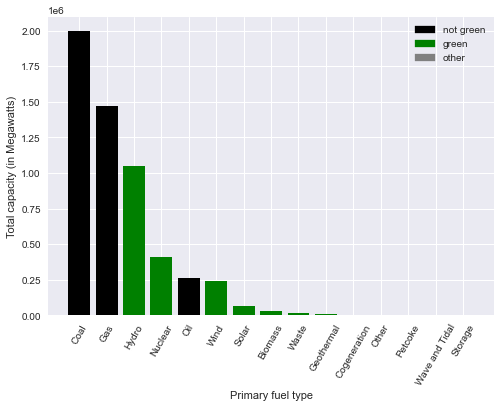

In [7]:
# https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column
plt.style.use('seaborn')
colors = {'not green':"black", 'green':"green", 'other':"grey"}  
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
c = capacity['green'].apply(lambda x: colors[x])
plt.bar(capacity['primary_fuel'], capacity['capacity_sum'], color=c, label=colors)
plt.xticks(rotation = 60)
plt.xlabel("Primary fuel type")
plt.ylabel("Total capacity (in Megawatts)", rotation = 90)
plt.legend(handles, labels)

**Interpretation:**
Not surprisingly, we see that the first two fuel types are Coal and Gas. However, Hydro also is in the top-three. Nuclear and Oil power plants also seem to be considerable energy producers.

## 2. How many new powerplants in total and of each new fuel type per year (or per n years)

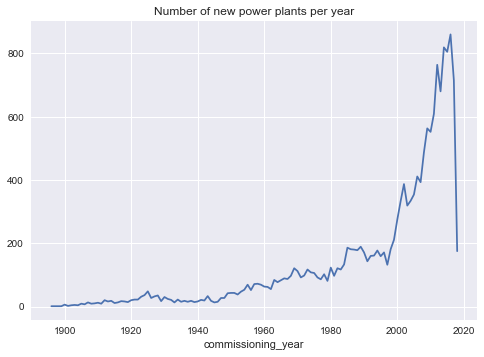

In [8]:
# https://stackoverflow.com/questions/11285613/selecting-multiple-columns-in-a-pandas-dataframe
newpp = df_all[['gppd_idnr','country','primary_fuel','commissioning_year']]
newpp = newpp.dropna()
newpp['commissioning_year'] = newpp['commissioning_year'].map(int)
newyear = newpp.groupby('commissioning_year')
nycount = newyear.size()
nycountplot = nycount.plot(title = "Number of new power plants per year")

**Interpretation:**  Important to note that the energy output data is available only until 2017. We also see a suspicious drop in the amount of new power plants from 2017 to 2018. The latest technical note for the dataset was published in 2019, but almost all sources used are from 2018 (also powerplant data sources). It seems likely that the dataset does not represent the number of new powerplants in 2018 adequately. Therefore, we only include the data from 1896-2017, and explore which fyel types are responsible for the spike(s):

<AxesSubplot:xlabel='Year'>

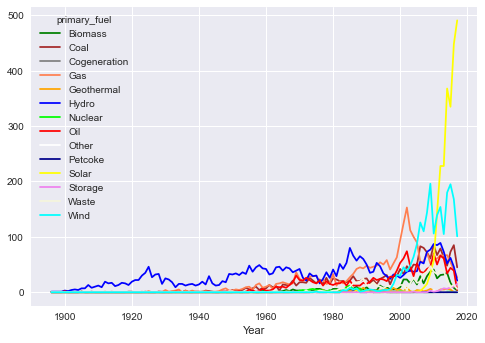

In [9]:
maskyear = newpp["commissioning_year"] != 2018
newpp = newpp[maskyear]
newyear = newpp.groupby('commissioning_year')
nycount = newyear.size()
pd.crosstab(newpp["commissioning_year"],newpp["primary_fuel"]).plot(xlabel = "Year", color = ['green','brown','grey','coral','orange','blue','lime','red','white','darkblue','yellow','violet','beige','cyan'])

<AxesSubplot:xlabel='Year'>

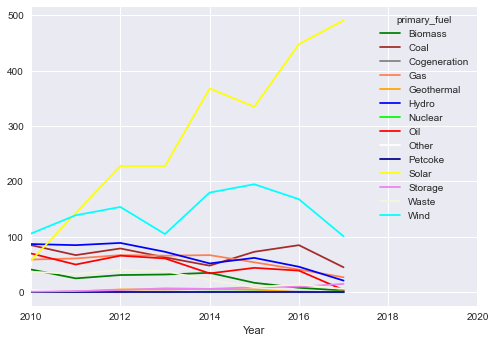

In [10]:
# Zoomed in for 2010-2017 period:
pd.crosstab(newpp["commissioning_year"],newpp["primary_fuel"]).plot(xlim = (2010,2020), xlabel = "Year", color = ['green','brown','grey','coral','orange','blue','lime','red','white','darkblue','yellow','violet','beige','cyan'])

**Interpretation:** We see that in the recent years, there has been a considerable increase in the number of Solar power plants. We also see that there has been as light increase in the number of new Wind power plants. While not as prominent, there have been new Hydro, Coal, Geothermal, Oil, Biomass power plants. An interesting question is: which countries are repsponsible for sucha  big rise in new Solar power plants?

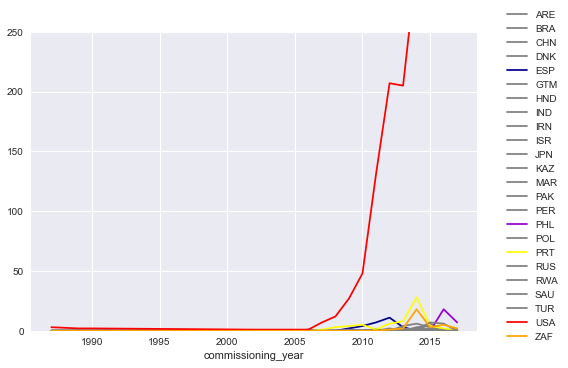

In [11]:
# Exploring which countries are responsible for the spike in solar power plants:
masksolar = newpp["primary_fuel"] == 'Solar'
newsolar = newpp[masksolar]
pd.crosstab(newsolar["commissioning_year"], newsolar["country"]).plot(color = ['grey','grey','grey','grey','darkblue','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey','darkviolet','grey','yellow','grey','grey','grey','grey','red','orange'])
plt.ylim(0,250)
plt.legend(bbox_to_anchor=(1.2,1.1))

(0.0, 50.0)

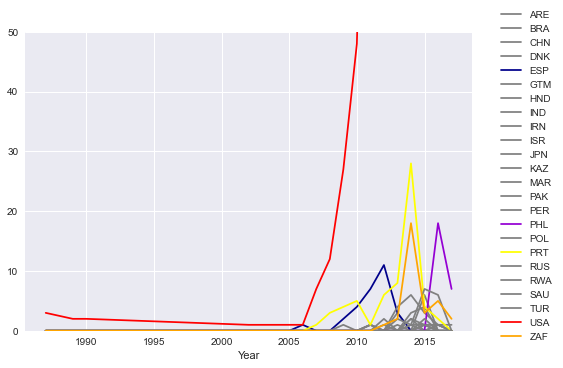

In [12]:
# Zoomed in
pd.crosstab(newsolar["commissioning_year"],newsolar["country"]).plot(xlabel = "Year", color = ['grey','grey','grey','grey','darkblue','grey','grey','grey','grey','grey','grey','grey','grey','grey','grey','darkviolet','grey','yellow','grey','grey','grey','grey','red','orange'])
plt.legend( bbox_to_anchor=(1.2,1.1))
plt.ylim(0,50)

**Interpretation:** We see that the most new power plants have been built in USA, but also there has been quite a few new Solar power plants in Spain, Philippines, South Africa, Portugal.

## 3. Ratio green energy estimated output over all estimated output (per country)

In [13]:
# Creates new column 'avg_annual_output' in df by
#  - copying estimated_generation_gwh in rows where it is not NaN
#  - averaging the time series in the remaining rows
def annual_output(df):
    df['avg_annual_output'] = df['estimated_generation_gwh']    
    idx = df.index[df['estimated_generation_gwh'].isna()].tolist()    
    df.loc[idx,'avg_annual_output'] = df[['generation_gwh_2013', 'generation_gwh_2014', 'generation_gwh_2015', 'generation_gwh_2016', 'generation_gwh_2017']].mean(axis=1)

In [14]:
annual_output(df_all)
df_all["green"] = df_all["primary_fuel"].map({'Gas':0,'Coal':0,'Oil':0,'Petcoke':0,'Other':0,'Cogeneration':1,'Storage':1,'Waste':1, 'Wind':1,'Hydro':1,'Solar':1,'Nuclear':1,'Biomass':1,'Geothermal':1,'Wave and Tidal':1})
maskgreen = df_all['green'] == 1
df_all_green = df_all[maskgreen]

# The green ratio for all the entire dataset
df_all_green['estimated_generation_gwh'].sum()/df_all['estimated_generation_gwh'].sum()

0.3363620725777442

<BarContainer object of 164 artists>

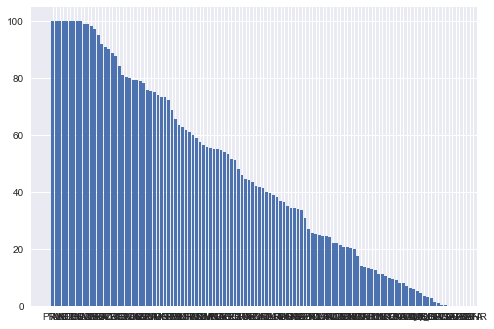

In [15]:
df_all_g = df_all.groupby('country')
df_all_green_g = df_all_green.groupby('country')
totalratiocountry = 100*df_all_green_g['estimated_generation_gwh'].sum()/df_all_g['estimated_generation_gwh'].sum()
totalratiocountry=totalratiocountry.to_frame()
totalratiocountry.reset_index(inplace=True)
totalratiocountry = totalratiocountry.sort_values('estimated_generation_gwh', ascending=False)
totalratiocountry = totalratiocountry.rename(columns={'estimated_generation_gwh':'green_ratio'})
countr = totalratiocountry.groupby('green_ratio')
plt.bar(totalratiocountry['country'],totalratiocountry['green_ratio'])

In [16]:
# Paraguay, Tajikistan, Albania, Mozambique, Nepal, Ethiopia, Switzerland and Iceland have 100 percent green ratio!
# (Googled the country codes)
print(totalratiocountry[totalratiocountry['green_ratio']==100])

    country  green_ratio
127     PRY        100.0
146     TJK        100.0
2       ALB        100.0
105     MOZ        100.0
116     NPL        100.0
50      ETH        100.0
26      CHE        100.0
74      ISL        100.0


In [17]:
# checking the original dataset
masknpl = df_all['country'] == 'NPL'
npl = df_all[masknpl]
npl

,country,name,gppd_idnr,capacity_mw,latitude,longitude,primary_fuel,other_fuel1,other_fuel2,other_fuel3,...,source,year_of_capacity_data,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,estimated_generation_gwh,avg_annual_output,green
14528,NPL,Bhote Koshi Hydroelectric Power Plant Nepal,GEODB0040476,45.00,27.9388,85.9450,Hydro,NaN,NaN,NaN,...,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,305.591899,305.591899,1
14529,NPL,Devighat Hydroelectric Power Plant Nepal,GEODB0040484,14.10,27.9212,85.1462,Hydro,NaN,NaN,NaN,...,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,95.752128,95.752128,1
14530,NPL,Gandak Hydroelectric Power Plant Nepal,GEODB0044203,15.00,27.4268,83.7918,Hydro,NaN,NaN,NaN,...,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,101.863966,101.863966,1
14531,NPL,Kali Gandaki Hydroelectric Power Plant Nepal,GEODB0040475,144.00,27.9760,83.5680,Hydro,NaN,NaN,NaN,...,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,977.894077,977.894077,1
14532,NPL,Khimti Hydroelectric Power Plant Nepal,GEODB0040485,60.00,27.5500,86.1690,Hydro,NaN,NaN,NaN,...,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,407.455865,407.455865,1
14533,NPL,Kulekhani-I Hydroelectric Power Plant Nepal,GEODB0040480,60.00,27.5900,85.1550,Hydro,NaN,NaN,NaN,...,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,407.455865,407.455865,1
14534,NPL,Kulekhani-II Hydroelectric Power Plant Nepal,GEODB0040482,32.00,27.5090,85.0519,Hydro,NaN,NaN,NaN,...,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,217.309795,217.309795,1
14535,NPL,Marsyangdi Hydroelectric Power Plant Nepal,GEODB0040477,69.00,27.9262,84.4965,Hydro,NaN,NaN,NaN,...,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,468.574245,468.574245,1
14536,NPL,Middle Marsyangdi Hydroelectric Power Plant Nepal,GEODB0040478,70.00,28.1890,84.4195,Hydro,NaN,NaN,NaN,...,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,475.365176,475.365176,1
14537,NPL,Modi Khola Hydroelectric Power Plant Nepal,GEODB0043974,14.80,28.2720,83.7411,Hydro,NaN,NaN,NaN,...,GEODB,2017.0,NaN,NaN,NaN,NaN,NaN,100.505780,100.505780,1


In [18]:
#53 countries with green ratio of >= 50
totalratiocountry[totalratiocountry['green_ratio']>=50].nunique()

country        53
green_ratio    46
dtype: int64

**Interpretation:** We see that while there are countries with 100% green ratio and 53 countries with green ration of >= 50%, the total green ratio for all power plants in the data set is only apprx. 33.6%.

## 4. Ratio green energy capacity over all capacity (per country)

<BarContainer object of 164 artists>

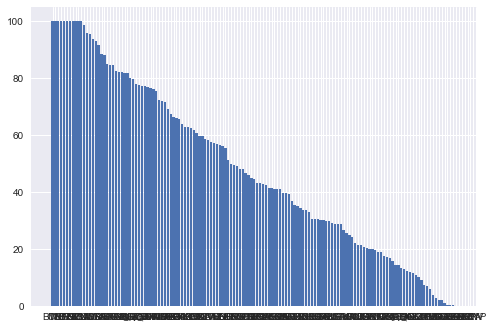

In [19]:
trcapacity = df_all_green_g['capacity_mw'].sum()*100/df_all_g['capacity_mw'].sum()
# https://stackoverflow.com/questions/40224319/pandas-series-to-dataframe-using-series-indexes-as-columns
trcapacity=trcapacity.to_frame()
trcapacity.reset_index(inplace=True)
trcapacity = trcapacity.sort_values('capacity_mw', ascending=False)
trcapacity = trcapacity.rename(columns={'capacity_mw':'green_ratio_capacity'})
plt.bar(trcapacity['country'],trcapacity['green_ratio_capacity'])

In [20]:
# Bhutan, Mali, Zwitzerland, Mozambique, Ethiopia, Paraguay, Eswatini, Iceland, Nepal, Burundi, Lesotho have 
# green capacity ratio of 100! # (Googled the country codes)
print(trcapacity[trcapacity['green_ratio_capacity']==100])

    country  green_ratio_capacity
22      BTN                 100.0
101     MLI                 100.0
26      CHE                 100.0
105     MOZ                 100.0
50      ETH                 100.0
127     PRY                 100.0
142     SWZ                 100.0
74      ISL                 100.0
116     NPL                 100.0
10      BDI                 100.0
92      LSO                 100.0


**Interpretation:** The results are similar to the results above with calculations on the estimated average. It is surprising, however, that some countries (Bhutan, Mali and Lesotho) with 100% green capacity ratio do not have 100% estimated output ratio. A quick check, however, shows that this is because all energy output values are 'NaN' for Bhutan, Mali and Lesotho.

# Maps on full dataset

In [21]:
#fig = px.scatter_geo(df_all,
#                    lat=df_all["latitude"],
#                    lon=df_all["longitude"],
#                    hover_name=df_all["name"],
#                    color = df_all["primary_fuel"])
#fig.show(#)

In [22]:
#df = df.groupby(['country', 'primary_fuel'], as_index = False)[["capacity_mw"]].sum() # groups countries by primary fuel types along with their aggregate capacity
#df = df.sort_values(['country','capacity_mw'], ascending = [True, False], ignore_index = True) # sorts countries by maximum capacity for each fuel type
#df = df.drop_duplicates(subset=['country'], keep='first', ignore_index = True) # only keeps the fuel type with highest maximum capacity
#df

df_pf = (df_all.groupby(['country', 'primary_fuel'], as_index = False)[["capacity_mw"]].sum()
        .sort_values(['country','capacity_mw'], ascending = [True, False], ignore_index = True)
        .drop_duplicates(subset=['country'], keep='first', ignore_index = True))

In [23]:

# Try with dictionary???
colors = {'Solar':'yellow', 
          'Gas':'lightgreen', 
          'Oil':'olive', 
          'Wind':'cyan', 
          'Hydro':'blue', 
          'Coal':'black', 
          'Biomass':'green', 
          'Waste':'brown', 
          'Cogeneration':'bisque', 
          'Geothermal':'red', 
          'Nuclear':'orange', 
          'Petcoke':'teal', 
          'Other':'grey', 
          'Storage':'lime'}


# plots the countries based on the most used primary fuel types
#fig = px.choropleth(df_pf, locations=df_pf["country"],
#                    hover_name=df_pf["country"],
#                    color = df_pf["primary_fuel"],
#                    color_continuous_scale=px.colors.sequential.Plasma)
#fig.show()

In [24]:
#fig = px.scatter_geo(df,
#                    lat=df["latitude"],
#                    lon=df["longitude"],
#                    hover_name=df["name"],
#                    color = df["primary_fuel"])
#fig.show()

# Complete Time Series Analysis

## 1. Comparison by Year: Boxplot

In [25]:
annual_output(df_ts_complete)
dfc=df_ts_complete[["generation_gwh_2013","generation_gwh_2014","generation_gwh_2015","generation_gwh_2016","generation_gwh_2017"]]
dfc.describe()

,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017
count,6817.000000,6817.000000,6817.000000,6817.000000,6817.000000
mean,685.020952,688.554481,698.562305,676.278993,726.536342
std,2261.173937,2294.095823,2304.707671,2279.047703,2341.640875
min,-947.600000,-989.619000,-864.428000,-768.620000,-934.944000
25%,2.200000,2.632000,2.511000,2.490000,4.348000
50%,27.118000,26.836320,26.576000,25.858000,36.726000
75%,250.443889,247.330068,251.239000,246.354000,283.000000
max,31431.080000,32320.917000,32525.595000,32377.477000,35116.000000


In [26]:
dfc.corr()

,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017
generation_gwh_2013,1.000000,0.962601,0.940071,0.913186,0.920023
generation_gwh_2014,0.962601,1.000000,0.972677,0.945576,0.932240
generation_gwh_2015,0.940071,0.972677,1.000000,0.967203,0.950799
generation_gwh_2016,0.913186,0.945576,0.967203,1.000000,0.954612
generation_gwh_2017,0.920023,0.932240,0.950799,0.954612,1.000000


**Boxplots with outliers:**

Text(0, 0.5, 'Energy output (in GWh)')

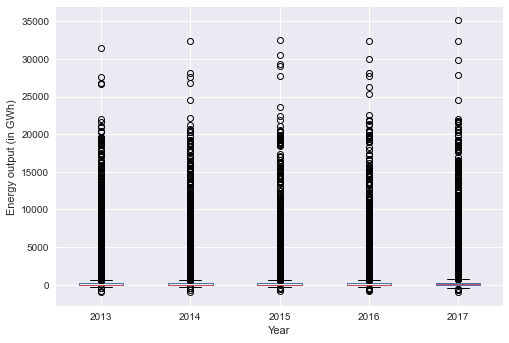

In [27]:
# https://stackoverflow.com/questions/11285613/selecting-multiple-columns-in-a-pandas-dataframe
# https://stackoverflow.com/questions/49554139/boxplot-of-multiple-columns-of-a-pandas-dataframe-on-the-same-figure-seaborn
dfc.boxplot(showfliers=True) # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html
plt.xticks([1,2,3,4,5], [2013,2014,2015,2016,2017])
plt.xlabel("Year")
plt.ylabel("Energy output (in GWh)")

**Boxplots without outliers:**

Text(0, 0.5, 'Energy output (in GWh)')

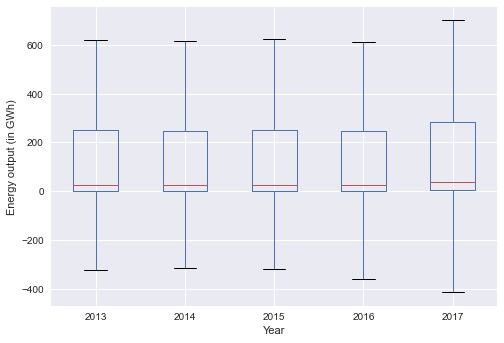

In [28]:
# https://stackoverflow.com/questions/11285613/selecting-multiple-columns-in-a-pandas-dataframe
# https://stackoverflow.com/questions/49554139/boxplot-of-multiple-columns-of-a-pandas-dataframe-on-the-same-figure-seaborn
dfc.boxplot(showfliers=False) # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html
plt.xticks([1,2,3,4,5], [2013,2014,2015,2016,2017])
plt.xlabel("Year")
plt.ylabel("Energy output (in GWh)")

**Interpretation:** It seems like there is a slight rise in energy production from 2013 to 2017, judging by the mean and max values above. However, the boxplots do not seem to show a significant difference. So, is there an increase in energy output throughout the years? Let's use ANOVA hypothesis testing as outlined in the hypothesis testing lecture from the Data Analysis course. So the null hypothesis is that the mean is similar for all 5 years (2013,2014,2015,2016 and 2017). And the alternative hypothesis is that there is a difference between the means.

## 2. Hypothesis Testing

### All

In [29]:
from scipy.stats import f_oneway
f_oneway(dfc["generation_gwh_2013"],dfc["generation_gwh_2014"],dfc["generation_gwh_2015"],dfc["generation_gwh_2016"],dfc["generation_gwh_2017"])

F_onewayResult(statistic=0.48443102568775964, pvalue=0.7472116879358542)

**Interpretation:** We see that the p-value is quite high, and definitely bigger than the standard 0.05 value. Therefore, we can conclude that the difference in the means between years is most likely due to chance, and that the difference in the means between years is not statistically significant. Let's see if there is a difference year-by-year using the t-test, as outlined in the hypothesis testing lecture from the Data Analysis course:

In [30]:
from scipy.stats import ttest_ind
t34, pval34 = ttest_ind(dfc["generation_gwh_2013"],dfc["generation_gwh_2014"])
print(t34, pval34)

-0.09057218720579535 0.9278338631635166


In [31]:
t45, pval45= ttest_ind(dfc["generation_gwh_2014"],dfc["generation_gwh_2015"])
print(t45, pval45)

-0.25410037001138785 0.7994218499512872


In [32]:
t56, pval56 = ttest_ind(dfc["generation_gwh_2015"],dfc["generation_gwh_2016"])
print(t56, pval56)

0.5676271408477459 0.5702975217343101


In [33]:
t67, pval67 = ttest_ind(dfc["generation_gwh_2016"],dfc["generation_gwh_2017"])
print(t67, pval67)

-1.2698858284702281 0.20414697778985053


**Interpretation:** There does not seem to be a significant difference as all p-values are higher than 0.05. The p-value steadily decrease with years, though. Now, it would be interesting to look specifically at Solar and Wind energy outputs, as from the plots above we see that there have been quite a lot of new power plants of these fuel types.

### Solar and Wind only

In [34]:
dfc1=df_ts_complete[["primary_fuel","generation_gwh_2013","generation_gwh_2014","generation_gwh_2015","generation_gwh_2016","generation_gwh_2017"]]
solar= dfc1[dfc1["primary_fuel"].str.contains('Solar')==True] 
solar.describe()

,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017
count,614.000000,614.000000,614.000000,614.000000,614.000000
mean,14.176807,23.480800,25.716058,25.673569,25.304770
std,45.808663,86.351426,97.053440,95.958802,95.268087
min,-0.116000,-0.064000,0.000000,0.000000,-0.394000
25%,1.648575,2.133587,2.145498,2.269750,2.084500
50%,2.812500,3.854000,4.003000,4.190500,3.851500
75%,8.333750,10.263250,10.188000,10.652750,10.362750
max,675.525000,1105.857000,1301.337000,1265.760000,1237.532000


In [35]:
from scipy.stats import f_oneway
f_oneway(solar["generation_gwh_2013"],solar["generation_gwh_2014"],solar["generation_gwh_2015"],solar["generation_gwh_2016"],solar["generation_gwh_2017"])

F_onewayResult(statistic=2.01529196320594, pvalue=0.0896483294449274)

**Interpretation:** The p-value is pretty small, but still a bit bigger than 0.05. Let's look year-by-year:

In [36]:
t34, pval34 = ttest_ind(solar["generation_gwh_2013"],solar["generation_gwh_2014"])
print(t34, pval34)

-2.3585122543025503 0.01850459918420546


In [37]:
t45, pval45= ttest_ind(solar["generation_gwh_2014"],solar["generation_gwh_2015"])
print(t45, pval45)

-0.4263614978350083 0.6699193003742298


In [38]:
t56, pval56 = ttest_ind(solar["generation_gwh_2015"],solar["generation_gwh_2016"])
print(t56, pval56)

0.007713999875312193 0.9938464346216915


In [39]:
t67, pval67 = ttest_ind(solar["generation_gwh_2016"],solar["generation_gwh_2017"])
print(t67, pval67)

0.06758297931762636 0.9461286246538121


**Interpretation:** So only for 2013-2014, the difference in mean could have been statistically significant. This is interesting, considering how many new power plants there have been built in 2010-2017, and that the country which seems to be responsible for the spike in new solar power plants seem to be the US (which is included in the complete time series dataset). Let's not look at wind:

In [40]:
wind = dfc1[dfc1["primary_fuel"].str.contains('Wind')==True] 
wind["primary_fuel"].unique()
wind.describe()

,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017
count,815.000000,815.000000,815.000000,815.000000,815.000000
mean,212.506884,225.655921,209.646224,216.898017,211.177503
std,242.456165,259.101596,236.785529,245.592186,240.213925
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.775500,24.560000,23.010000,22.551000,21.528000
50%,136.132000,147.864000,140.907000,145.288000,144.709000
75%,332.800500,353.121000,326.288000,332.927500,319.801500
max,1983.817000,2309.100000,1965.895000,2159.583000,1972.964000


In [41]:
from scipy.stats import f_oneway
f_oneway(wind["generation_gwh_2013"],wind["generation_gwh_2014"],wind["generation_gwh_2015"],wind["generation_gwh_2016"],wind["generation_gwh_2017"])

F_onewayResult(statistic=0.5653461294129226, pvalue=0.6878214078615505)

In [42]:
t34, pval34 = ttest_ind(wind["generation_gwh_2013"],wind["generation_gwh_2014"])
print(t34, pval34)

-1.0578589477547202 0.29027669098917025


In [43]:
t45, pval45= ttest_ind(wind["generation_gwh_2014"],wind["generation_gwh_2015"])
print(t45, pval45)

1.3021312251271024 0.1930557239637976


In [44]:
t56, pval56 = ttest_ind(wind["generation_gwh_2015"],wind["generation_gwh_2016"])
print(t56, pval56)

-0.6068475692598173 0.5440366937343956


In [45]:
t67, pval67 = ttest_ind(wind["generation_gwh_2016"],wind["generation_gwh_2017"])
print(t67, pval67)

0.47537824151956065 0.6345811733992572


**Interpretation:** Not statistically significant.

## 3. Stacked barplot energy output per fuel type (separate for each country)

In [46]:
dfc2=df_ts_complete[["country","primary_fuel","generation_gwh_2013","generation_gwh_2014","generation_gwh_2015","generation_gwh_2016","generation_gwh_2017"]]
aus = dfc2[dfc2["country"].str.contains('AUS')==True] 
ind = dfc2[dfc2["country"].str.contains('IND')==True] 
usa = dfc2[dfc2["country"].str.contains('USA')==True] 
ausfuel = aus.groupby("primary_fuel")

# https://towardsdatascience.com/pandas-groupby-aggregate-transform-filter-c95ba3444bbb
ausfuel = ausfuel.agg(**{'generation_2013_sum': pd.NamedAgg(column='generation_gwh_2013', aggfunc='sum'), 'generation_2014_sum': pd.NamedAgg(column='generation_gwh_2014', aggfunc='sum'),'generation_2015_sum': pd.NamedAgg(column='generation_gwh_2015', aggfunc='sum'),'generation_2016_sum': pd.NamedAgg(column='generation_gwh_2016', aggfunc='sum'),'generation_2017_sum': pd.NamedAgg(column='generation_gwh_2017', aggfunc='sum')})
ausfuel = ausfuel.sort_values(by='generation_2013_sum', ascending = False)
ausfuel = ausfuel.transpose() # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transpose.html
ausfuel = ausfuel.reset_index()

indfuel = ind.groupby("primary_fuel")
# https://towardsdatascience.com/pandas-groupby-aggregate-transform-filter-c95ba3444bbb
indfuel = indfuel.agg(**{'generation_2013_sum': pd.NamedAgg(column='generation_gwh_2013', aggfunc='sum'), 'generation_2014_sum': pd.NamedAgg(column='generation_gwh_2014', aggfunc='sum'),'generation_2015_sum': pd.NamedAgg(column='generation_gwh_2015', aggfunc='sum'),'generation_2016_sum': pd.NamedAgg(column='generation_gwh_2016', aggfunc='sum'),'generation_2017_sum': pd.NamedAgg(column='generation_gwh_2017', aggfunc='sum')})
indfuel = indfuel.sort_values(by='generation_2013_sum', ascending = False)
indfuel = indfuel.transpose() # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transpose.html
indfuel = indfuel.reset_index()

usafuel = usa.groupby("primary_fuel")
# https://towardsdatascience.com/pandas-groupby-aggregate-transform-filter-c95ba3444bbb
usafuel = usafuel.agg(**{'generation_2013_sum': pd.NamedAgg(column='generation_gwh_2013', aggfunc='sum'), 'generation_2014_sum': pd.NamedAgg(column='generation_gwh_2014', aggfunc='sum'),'generation_2015_sum': pd.NamedAgg(column='generation_gwh_2015', aggfunc='sum'),'generation_2016_sum': pd.NamedAgg(column='generation_gwh_2016', aggfunc='sum'),'generation_2017_sum': pd.NamedAgg(column='generation_gwh_2017', aggfunc='sum')})
usafuel = usafuel.sort_values(by='generation_2013_sum', ascending = False)
usafuel = usafuel.transpose() # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.transpose.html
usafuel = usafuel.reset_index()

Text(0.5, 1.0, 'Australia')

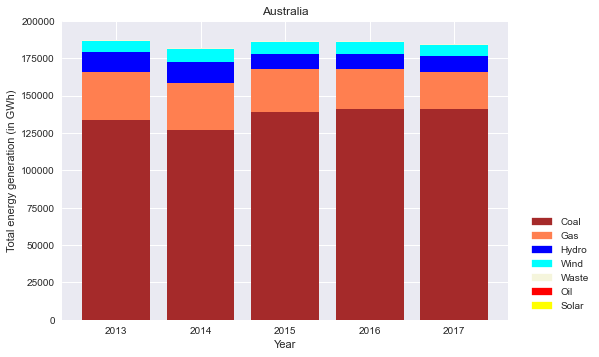

In [47]:
# https://stackoverflow.com/questions/44309507/stacked-bar-plot-using-matplotlib
p1 = plt.bar(ausfuel["index"], ausfuel["Coal"], color='brown')
p2 = plt.bar(ausfuel["index"], ausfuel["Gas"] ,bottom = ausfuel["Coal"], color='coral')
p3 = plt.bar(ausfuel["index"], ausfuel["Hydro"],
             bottom=[sum(x) for x in zip(ausfuel["Coal"],ausfuel["Gas"])], color='blue')
p4 = plt.bar(ausfuel["index"], ausfuel["Wind"],
             bottom=[sum(x) for x in zip(ausfuel["Coal"],ausfuel["Gas"],ausfuel["Hydro"])],
             color='cyan')
p5 = plt.bar(ausfuel["index"], ausfuel["Waste"],
             bottom=[sum(x) for x in zip(ausfuel["Coal"],ausfuel["Gas"],ausfuel["Hydro"], ausfuel["Wind"])],
             color='beige')
p6 = plt.bar(ausfuel["index"], ausfuel["Oil"],
             bottom=[sum(x) for x in zip(ausfuel["Coal"],ausfuel["Gas"],ausfuel["Hydro"], ausfuel["Wind"],ausfuel["Waste"])],
             color='red')
p7 = plt.bar(ausfuel["index"], ausfuel["Solar"],
             bottom=[sum(x) for x in zip(ausfuel["Coal"],ausfuel["Gas"],ausfuel["Hydro"], ausfuel["Wind"],ausfuel["Waste"],ausfuel["Oil"])],
             color='yellow')
plt.ylim(0,200000)
plt.xticks([0,1,2,3,4], [2013,2014,2015,2016,2017])

# https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column
colors = {'Coal':"brown", 'Gas':"coral", 'Hydro':"blue","Wind":"cyan", "Waste":"beige","Oil":"red","Solar":"yellow"}  
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
plt.legend(handles, labels, loc = 'lower right', bbox_to_anchor=(1.2, 0))
plt.xlabel("Year")
plt.ylabel("Total energy generation (in GWh)")
plt.title("Australia")

Text(0.5, 1.0, 'India')

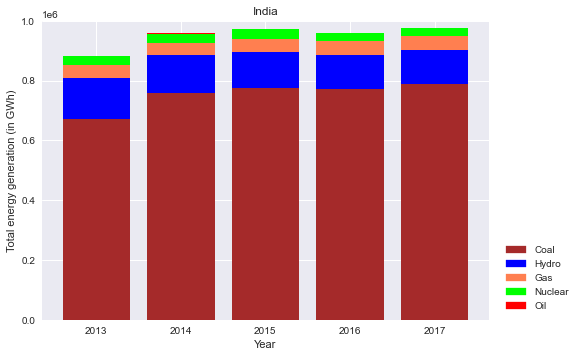

In [48]:
# https://stackoverflow.com/questions/44309507/stacked-bar-plot-using-matplotlib
p1 = plt.bar(indfuel["index"], indfuel["Coal"], color='brown')
p2 = plt.bar(indfuel["index"], indfuel["Hydro"] ,bottom = indfuel["Coal"], color='blue')
p3 = plt.bar(indfuel["index"], indfuel["Gas"],
             bottom=[sum(x) for x in zip(indfuel["Coal"],indfuel["Hydro"])], color='coral')
p4 = plt.bar(indfuel["index"], indfuel["Nuclear"],
             bottom=[sum(x) for x in zip(indfuel["Coal"],indfuel["Hydro"],indfuel["Gas"])],
             color='lime')
p5 = plt.bar(indfuel["index"], indfuel["Oil"],
             bottom=[sum(x) for x in zip(indfuel["Coal"],indfuel["Hydro"],indfuel["Gas"], indfuel["Nuclear"])],
             color='red')
plt.ylim(0,1000000)
plt.xticks([0,1,2,3,4], [2013,2014,2015,2016,2017])

# https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column
colors = {'Coal':"brown", 'Hydro':"blue", 'Gas':"coral", "Nuclear":"lime","Oil":"red"}  
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
plt.legend(handles, labels, loc = 'lower right', bbox_to_anchor=(1.2, 0))
plt.xlabel("Year")
plt.ylabel("Total energy generation (in GWh)")
plt.title("India")

Text(0.5, 1.0, 'USA')

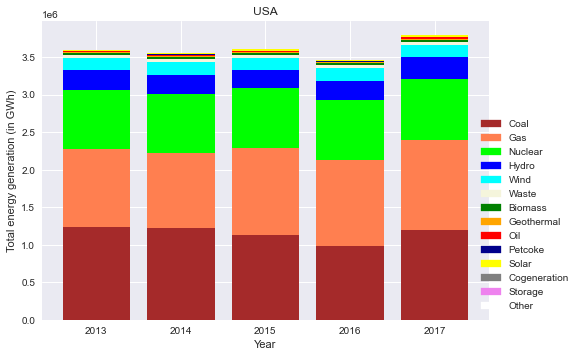

In [49]:
# https://stackoverflow.com/questions/44309507/stacked-bar-plot-using-matplotlib
p1 = plt.bar(usafuel["index"], usafuel["Coal"], color='brown')
p2 = plt.bar(usafuel["index"], usafuel["Gas"] ,bottom = usafuel["Coal"], color='coral')
p3 = plt.bar(usafuel["index"], usafuel["Nuclear"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"])], color='lime')
p4 = plt.bar(usafuel["index"], usafuel["Hydro"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"])],
             color='blue')
p5 = plt.bar(usafuel["index"], usafuel["Wind"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"])],
             color='cyan')
p6 = plt.bar(usafuel["index"], usafuel["Waste"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"],usafuel["Wind"])],
             color='beige')
p7 = plt.bar(usafuel["index"], usafuel["Biomass"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"],usafuel["Wind"],usafuel["Waste"])],
             color='green')
p8 = plt.bar(usafuel["index"], usafuel["Geothermal"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"],usafuel["Wind"],usafuel["Waste"],usafuel["Biomass"])],
             color='orange')
p9 = plt.bar(usafuel["index"], usafuel["Oil"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"],usafuel["Wind"],usafuel["Waste"],usafuel["Biomass"],usafuel["Geothermal"])],
             color='red')
p10 = plt.bar(usafuel["index"], usafuel["Petcoke"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"],usafuel["Wind"],usafuel["Waste"],usafuel["Biomass"],usafuel["Geothermal"],usafuel["Oil"])],
             color='darkblue')
p11 = plt.bar(usafuel["index"], usafuel["Solar"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"],usafuel["Wind"],usafuel["Waste"],usafuel["Biomass"],usafuel["Geothermal"],usafuel["Oil"],usafuel["Petcoke"])],
             color='yellow')
p12 = plt.bar(usafuel["index"], usafuel["Cogeneration"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"],usafuel["Wind"],usafuel["Waste"],usafuel["Biomass"],usafuel["Geothermal"],usafuel["Oil"],usafuel["Petcoke"],usafuel["Solar"])],
             color='grey')
p13 = plt.bar(usafuel["index"], usafuel["Storage"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"],usafuel["Wind"],usafuel["Waste"],usafuel["Biomass"],usafuel["Geothermal"],usafuel["Oil"],usafuel["Petcoke"],usafuel["Solar"],usafuel["Cogeneration"])],
             color='violet')
p14 = plt.bar(usafuel["index"], usafuel["Other"],
             bottom=[sum(x) for x in zip(usafuel["Coal"],usafuel["Gas"],usafuel["Nuclear"], usafuel["Hydro"],usafuel["Wind"],usafuel["Waste"],usafuel["Biomass"],usafuel["Geothermal"],usafuel["Oil"],usafuel["Petcoke"],usafuel["Solar"],usafuel["Cogeneration"],usafuel["Storage"])],
             color='white')
plt.xticks([0,1,2,3,4], [2013,2014,2015,2016,2017])

# https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column
colors = {'Coal':"brown", 'Gas':"coral", "Nuclear":"lime", "Hydro":"blue","Wind":"cyan","Waste":"beige","Biomass":"green","Geothermal":"orange","Oil":"red","Petcoke":"darkblue","Solar":"yellow","Cogeneration":"grey","Storage":"violet","Other":"white"}  
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
plt.legend(handles, labels, loc = 'lower right', bbox_to_anchor=(1.2, 0))
plt.xlabel("Year")
plt.ylabel("Total energy generation (in GWh)")
plt.title("USA")

**Interpretation:** We see that Coal and Gas are still major energy providers for Australia, India and USA. Nuclear, Hydro and Wind energies are also relatively important.

## 4. Line plot: ratio of energy output sustainable fuel types over total energy output per year

Text(0.5, 1.0, 'Australia')

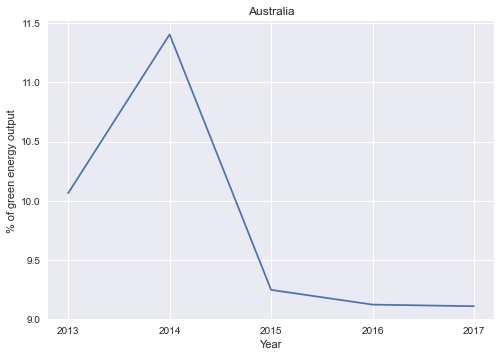

In [50]:
# https://stackoverflow.com/questions/34023918/make-new-column-in-panda-dataframe-by-adding-values-from-other-columns
ausfuel['green'] = ausfuel["Hydro"]+ausfuel["Wind"]+ausfuel["Waste"]+ausfuel["Solar"]
ausfuel['all'] = ausfuel[list(ausfuel.columns)].sum(axis=1)
ausfuel['greenpercent'] = ausfuel['green']*100/ausfuel['all']
ausfuel["greenpercent"].plot()
plt.xticks([0,1,2,3,4], [2013,2014,2015,2016,2017])
plt.xlabel("Year")
plt.ylabel("% of green energy output")
plt.title("Australia")

Text(0.5, 1.0, 'India')

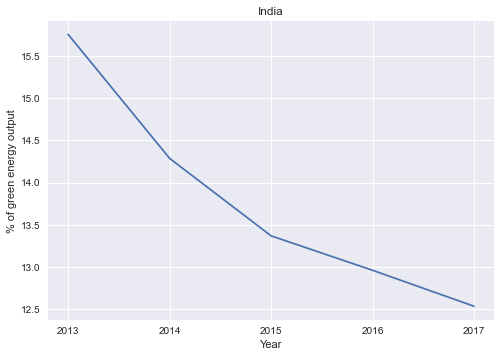

In [51]:
# https://stackoverflow.com/questions/34023918/make-new-column-in-panda-dataframe-by-adding-values-from-other-columns
indfuel['green'] = indfuel["Hydro"]+indfuel["Nuclear"]
indfuel['all'] = indfuel[list(indfuel.columns)].sum(axis=1)
indfuel['greenpercent'] = indfuel['green']*100/indfuel['all']
indfuel["greenpercent"].plot()
plt.xticks([0,1,2,3,4], [2013,2014,2015,2016,2017])
plt.xlabel("Year")
plt.ylabel("% of green energy output")
plt.title("India")

Text(0.5, 1.0, 'USA')

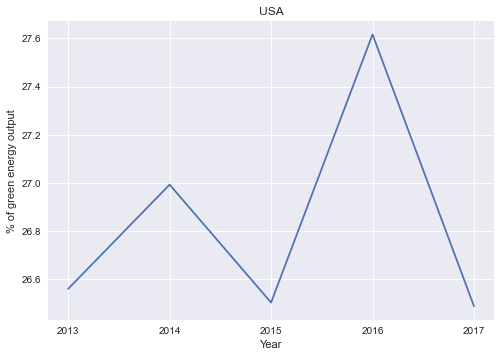

In [52]:
# https://stackoverflow.com/questions/34023918/make-new-column-in-panda-dataframe-by-adding-values-from-other-columns
usafuel['green'] = usafuel["Nuclear"]+usafuel["Hydro"]+usafuel["Wind"]+usafuel["Waste"]+usafuel["Biomass"]+usafuel["Geothermal"]+usafuel["Solar"]
usafuel['all'] = usafuel[list(usafuel.columns)].sum(axis=1)
usafuel['greenpercent'] = usafuel['green']*100/usafuel['all']
usafuel["greenpercent"].plot()
plt.xticks([0,1,2,3,4], [2013,2014,2015,2016,2017])
plt.xlabel("Year")
plt.ylabel("% of green energy output")
plt.title("USA")

**Interpretation:** We see that unfortunately, neither Australia nor India or USA has a clear constant upward trend in the percentage of green energy output, and that in 2017 that percentage actually decreased for all three countries when compared to 2013.

# Regression on the full dataset (predicting annual energy generation)

**Reminder:** annual energy generation is either the average of actually reported generations between 2013-2017, or the energy generation estimated by the database creators.

**Not accounting for multicolinearity:**

In [53]:
model1 = sm.ols(formula="avg_annual_output ~ capacity_mw+latitude+longitude+primary_fuel+green+commissioning_year", data=df_all).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      avg_annual_output   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     6797.
Date:                Sat, 20 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:50:26   Log-Likelihood:            -1.3427e+05
No. Observations:               16238   AIC:                         2.686e+05
Df Residuals:                   16220   BIC:                         2.687e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        568.6723    731.992      0.777      0.437    -866.112    2003.456
primary_fuel[T.Coal]             411.1120    131.890      3.117      0.002     152.593     669.631
primary_fuel[T.Cogeneration]    -130.7435    167.040     -0.783      0.434    -458.160     196.673
primary_fuel[T.Gas]             -188.5846    132.799     -1.420      0.156    -448.886      71.717
primary_fuel[T.Geothermal]       -61.2832     89.076     -0.688      0.491    -235.882     113.316
primary_fuel[T.Hydro]           -240.6978     44.128     -5.454      0.000    -327.194    -154.201
primary_fuel[T.Nuclear]         4896.7963    105.440     46.442      0.000    4690.123    5103.470
primary_fuel[T.Oil]               65.0899    132.829      0.490      0.624    -195.270     325.449
primary_fuel[T.Other]            -26.7000    197.202     -0.135      0.892    -413.237     359.837
primary_fuel[T.Petcoke]           33.2464    263.947      0.126      0.900    -484.119     550.612
primary_fuel[T.Solar]           -141.6454     45.949     -3.083      0.002    -231.711     -51.580
primary_fuel[T.Storage]         -100.0851    131.125     -0.763      0.445    -357.105     156.934
primary_fuel[T.Waste]            -98.4523     54.889     -1.794      0.073    -206.040       9.136
primary_fuel[T.Wave and Tidal] -4.854e-13   3.52e-14    -13.772      0.000   -5.54e-13   -4.16e-13
primary_fuel[T.Wind]            -212.1448     45.417     -4.671      0.000    -301.167    -123.122
capacity_mw                        4.0943      0.015    271.054      0.000       4.065       4.124
latitude                          -0.1783      0.379     -0.471      0.638      -0.920       0.564
longitude                          0.9447      0.125      7.554      0.000       0.700       1.190
green                            274.5086    135.962      2.019      0.044       8.008     541.009
commissioning_year                -0.3254      0.426     -0.765      0.444      -1.159       0.509
==============================================================================
Omnibus:                    17045.579   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         16577499.129
Skew:                           4.328   Prob(JB):                         0.00
Kurtosis:                     159.291   Cond. No.                     6.24e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.69e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Accounting for colinearity:**

In [54]:
model12 = sm.ols(formula="avg_annual_output ~ capacity_mw+latitude+longitude+primary_fuel+green+commissioning_year+capacity_mw*primary_fuel+capacity_mw*commissioning_year+primary_fuel*commissioning_year+latitude*longitude", data=df_all).fit()
model12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      avg_annual_output   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     3004.
Date:                Sat, 20 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:50:27   Log-Likelihood:            -1.3313e+05
No. Observations:               16238   AIC:                         2.664e+05
Df Residuals:                   16192   BIC:                         2.667e+05
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                           917.6560   8209.927      0.112      0.911   -1.52e+04     1.7e+04
primary_fuel[T.Coal]                               6679.7668   8480.097      0.788      0.431   -9942.160    2.33e+04
primary_fuel[T.Cogeneration]                       5928.3306   1.92e+04      0.309      0.757   -3.17e+04    4.35e+04
primary_fuel[T.Gas]                               -4231.0078   8373.825     -0.505      0.613   -2.06e+04    1.22e+04
primary_fuel[T.Geothermal]                         -937.8884   1.37e+04     -0.069      0.945   -2.77e+04    2.59e+04
primary_fuel[T.Hydro]                               1.03e+04   5335.251      1.930      0.054    -162.328    2.08e+04
primary_fuel[T.Nuclear]                            1.888e+05   1.89e+04      9.982      0.000    1.52e+05    2.26e+05
primary_fuel[T.Oil]                                -556.2020   8513.706     -0.065      0.948   -1.72e+04    1.61e+04
primary_fuel[T.Other]                             -1.645e+04   1.49e+04     -1.103      0.270   -4.57e+04    1.28e+04
primary_fuel[T.Petcoke]                             2.34e+04   4.73e+04      0.495      0.621   -6.93e+04    1.16e+05
primary_fuel[T.Solar]                              1.652e+04   1.42e+04      1.163      0.245   -1.13e+04    4.44e+04
primary_fuel[T.Storage]                            1.008e+04   8.87e+04      0.114      0.909   -1.64e+05    1.84e+05
primary_fuel[T.Waste]                              8613.8336   8068.842      1.068      0.286   -7201.989    2.44e+04
primary_fuel[T.Wave and Tidal]                      2.48e-07   1.54e-07      1.611      0.107   -5.37e-08     5.5e-07
primary_fuel[T.Wind]                               2.192e+04   8528.711      2.570      0.010    5197.810    3.86e+04
capacity_mw                                          -0.3880      1.909     -0.203      0.839      -4.130       3.354
capacity_mw:primary_fuel[T.Coal]                     -5.5403      0.764     -7.254      0.000      -7.037      -4.043
capacity_mw:primary_fuel[T.Cogeneration]             -6.9730      5.062     -1.377      0.168     -16.895       2.949
capacity_mw:primary_fuel[T.Gas]                      -6.6920      0.764     -8.758      0.000      -8.190      -5.194
capacity_mw:primary_fuel[T.Geothermal]               -5.5688      1.059     -5.256      0.000      -7.645      -3.492
capacity_mw:primary_fuel[T.Hydro]                    -6.1350      0.764     -8.032      0.000      -7.632      -4.638
capacity_mw:primary_fuel[T.Nuclear]                  -2.3785      0.771     -3.083      0.002      -3.891      -0.866
capacity_mw:primary_fuel[T.Oil]                      -7.1669      0.766     -9.351      0.000      -8.669      -5.665
capacity_mw:pri

**Interpretation:** We see that 'primary_fuel' variable on its own still can have low p-values but the combination of capacity and primary fuel looks much better in terms of p-values. 'Capacity_mw' and 'green' do not have low p-values anymore after accounting for multicolinearity. Latitude and Commissioning year did not have a high p-value from the very beginning, but the combination of longitude and latitude does, as well as the combination of 'capacity_mw' and 'commissioning_year'. Therefore, let's only keep 'longitude:latitude', 'primary_fuel:capacity' and 'capacity:commissioning_year' 

In [55]:
model123 = sm.ols(formula="avg_annual_output ~ latitude*longitude+capacity_mw*primary_fuel+capacity_mw*commissioning_year", data=df_all).fit()
model123.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      avg_annual_output   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     4193.
Date:                Sat, 20 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:50:27   Log-Likelihood:            -1.3319e+05
No. Observations:               16238   AIC:                         2.665e+05
Df Residuals:                   16205   BIC:                         2.667e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                   2135.3304    848.061      2.518      0.012     473.037    3797.624
primary_fuel[T.Coal]                        -101.7226     56.716     -1.794      0.073    -212.892       9.447
primary_fuel[T.Cogeneration]                 125.9374    216.312      0.582      0.560    -298.058     549.933
primary_fuel[T.Gas]                           -6.5028     51.351     -0.127      0.899    -107.157      94.151
primary_fuel[T.Geothermal]                   137.4925     95.676      1.437      0.151     -50.044     325.029
primary_fuel[T.Hydro]                        -22.6581     50.053     -0.453      0.651    -120.768      75.452
primary_fuel[T.Nuclear]                      -95.9477    195.660     -0.490      0.624    -479.462     287.567
primary_fuel[T.Oil]                          100.2061     51.630      1.941      0.052      -0.993     201.406
primary_fuel[T.Other]                        331.0723    194.785      1.700      0.089     -50.727     712.872
primary_fuel[T.Petcoke]                       54.0002    283.322      0.191      0.849    -501.342     609.342
primary_fuel[T.Solar]                        132.6592     51.718      2.565      0.010      31.287     234.031
primary_fuel[T.Storage]                      181.8035    157.410      1.155      0.248    -126.737     490.344
primary_fuel[T.Waste]                        140.1872     64.045      2.189      0.029      14.652     265.722
primary_fuel[T.Wave and Tidal]              7.054e-11    2.4e-09      0.029      0.977   -4.63e-09    4.77e-09
primary_fuel[T.Wind]                          75.8281     52.657      1.440      0.150     -27.386     179.042
latitude                                       0.2949      0.412      0.716      0.474      -0.512       1.102
longitude                                      0.8199      0.235      3.493      0.000       0.360       1.280
latitude:longitude                             0.0131      0.006      2.120      0.034       0.001       0.025
capacity_mw                                    1.5968      1.752      0.911      0.362      -1.838       5.031
capacity_mw:primary_fuel[T.Coal]              -5.3567      0.759     -7.060      0.000      -6.844      -3.869
capacity_mw:primary_fuel[T.Cogeneration]      -6.8276      5.065     -1.348      0.178     -16.755       3.100
capacity_mw:primary_fuel[T.Gas]               -6.4999      0.759     -8.562      0.000      -7.988      -5.012
capacity_mw:primary_fuel[T.Geothermal]        -5.4742      1.053     -5.196      0.000      -7.539      -3.409
capacity_mw:primary_fuel[T.Hydro]             -5.9496      0.759     -7.841      0.000      -7.437      -4.462
capacity_mw:primary_fuel[T.Nuclear]           -2.4047      0.766     -3.138      0.002